In [2]:

!wget -nc https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv

File ‘yellow_tripdata_2019-06.csv’ already there; not retrieving.



In [3]:
!pip install snapml==1.8.10

In [4]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

In [6]:
raw_data = pd.read_csv('yellow_tripdata_2019-06.csv')
raw_data.shape
raw_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


In [6]:
raw_data.shape

(3936004, 18)

In [7]:
raw_data = raw_data[raw_data['tip_amount'] > 0]

In [8]:
raw_data = raw_data[raw_data['tip_amount'] <= raw_data['fare_amount']]

In [9]:
raw_data = raw_data[(raw_data['fare_amount'] >= 2) & (raw_data['fare_amount'] < 200)]

In [10]:
clean_data = raw_data.drop(['total_amount'],axis = 1)

In [9]:
del raw_data
gc.collect()

71

In [11]:
clean_data.shape

(2712719, 17)

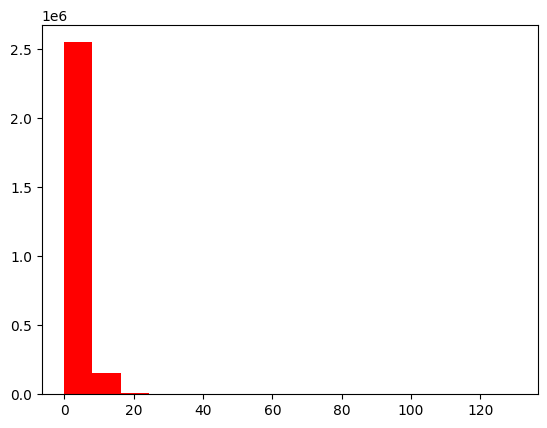

In [12]:
plt.hist(clean_data.tip_amount.values,16,histtype='bar',facecolor = 'red')
plt.show()

In [14]:
print(np.percentile(clean_data.tip_amount.values,90))

5.95


In [15]:
clean_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5


In [11]:
clean_data["tpep_pickup_datetime"] = pd.to_datetime(clean_data["tpep_pickup_datetime"])
clean_data["tpep_dropoff_datetime"] = pd.to_datetime(clean_data["tpep_dropoff_datetime"])
clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour
clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday
clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).dt.total_seconds()
first_n_rows = 200000
clean_data = clean_data.head(first_n_rows)

In [17]:
clean_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,pickup_hour,dropoff_hour,pickup_day,dropoff_day,trip_time
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,...,0.5,2.65,0.0,0.3,2.5,0,0,5,5,737.0
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,...,0.5,1.00,0.0,0.3,2.5,0,0,5,5,652.0
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,...,0.5,1.00,0.0,0.3,2.5,0,1,5,5,488.0
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,...,0.5,7.05,0.0,0.3,2.5,0,1,5,5,2041.0
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,...,0.5,2.96,0.0,0.3,2.5,0,0,5,5,858.0


In [12]:
clean_data = clean_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)


In [13]:
clean_data.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,pickup_hour,dropoff_hour,pickup_day,dropoff_day,trip_time
4,1,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5,0,0,5,5,737.0
5,1,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5,0,0,5,5,652.0
7,1,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5,0,1,5,5,488.0
9,1,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5,0,1,5,5,2041.0
10,2,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5,0,0,5,5,858.0


In [14]:
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(clean_data, columns = get_dummy_col)

In [15]:
del clean_data
gc.collect()

0

In [16]:
y = proc_data[['tip_amount']].values.astype('float32')






In [17]:
proc_data = proc_data.drop(['tip_amount'], axis=1)

In [18]:
X = proc_data.values

In [19]:
X = normalize(X, axis=1, norm='l1', copy=False)

In [20]:
X.shape

(200000, 517)

In [21]:
y.shape

(200000, 1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [24]:
from sklearn.tree import DecisionTreeRegressor
sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)
t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  7.30646


In [33]:
from snapml import DecisionTreeRegressor
snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45,n_jobs = 4)
t0 = time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time() - t0
print("[SnapML] Training time (s):  {0:.5f}".format(snapml_time))

[SnapML] Training time (s):  6.94874


In [34]:
sklearn_predict = sklearn_dt.predict(X_test)
snapml_predict = snapml_dt.predict(X_test)
sklearn_mse = mean_squared_error(y_test, sklearn_predict)
snapml_mse = mean_squared_error(y_test, snapml_predict)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

[Scikit-Learn] MSE score : 1.636
[Snap ML] MSE score : 1.655
